In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Importing libraries 

First of all, I imported all required libraries and set some initial values and parameters to be used through the entire notebook. Things like filtering out warnings and setting global variables are done here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# cross-validation libraries
from sklearn.model_selection import StratifiedKFold

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

# imbalanced class libraries
from imblearn.over_sampling import SMOTE, RandomOverSampler

# for tuning hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# other
from imblearn.pipeline import make_pipeline
import pickle as pkl
from collections import Counter
import warnings


# ignoring warnings
warnings.filterwarnings("ignore")

# set initial values
SEED = 42

# improve quality of graphs
%matplotlib inline

# 2. Reading file and Exploratory Data Analysis (EDA)

Before working with the file, I needed to import its content. I used pandas read_csv function for doing that. When I did it for the first time, I noticed there was an unnamed column, which was later used to indexing the rows.

In [2]:
# importing file and showing first 10 rows

tracks_df = pd.read_csv("/kaggle/input/-spotify-tracks-dataset/dataset.csv", index_col = 0)
tracks_df.head(10)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


After reading the file, I started looking at how the data is distributed. I also checked some statistical info and what was the kind of data on each column.

In [3]:
# getting base dataset info
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

In [4]:
# getting statistical info
tracks_df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


I also got its shape to check how many rows and columns it had.

In [5]:
# get dataframe shape
print(f"Shape of dataset: {tracks_df.shape}")

Shape of dataset: (114000, 20)


Then, I looked at the number of null values each column had

In [6]:
for column in tracks_df.columns:
    print(f"Number of null items in column {column}: {tracks_df[column].isnull().sum()}")

Number of null items in column track_id: 0
Number of null items in column artists: 1
Number of null items in column album_name: 1
Number of null items in column track_name: 1
Number of null items in column popularity: 0
Number of null items in column duration_ms: 0
Number of null items in column explicit: 0
Number of null items in column danceability: 0
Number of null items in column energy: 0
Number of null items in column key: 0
Number of null items in column loudness: 0
Number of null items in column mode: 0
Number of null items in column speechiness: 0
Number of null items in column acousticness: 0
Number of null items in column instrumentalness: 0
Number of null items in column liveness: 0
Number of null items in column valence: 0
Number of null items in column tempo: 0
Number of null items in column time_signature: 0
Number of null items in column track_genre: 0


And, finally, plotted a few graphs to check how was the data distribution for each column.

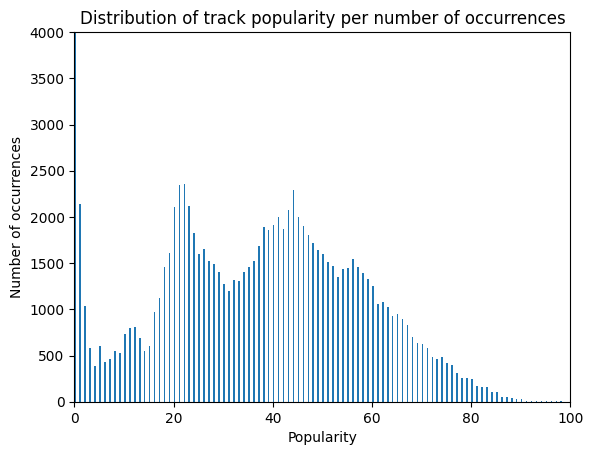

In [7]:
# get popularity distribution graph

plt.hist(tracks_df["popularity"].values, bins = 300)
plt.xlabel("Popularity")
plt.ylabel("Number of occurrences")
plt.title("Distribution of track popularity per number of occurrences")
plt.xlim(0, 100)
plt.ylim(0, 4000)
plt.show()

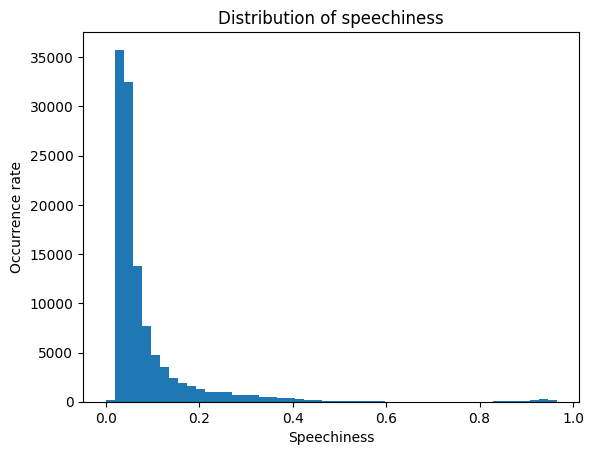

In [8]:
# get distribution of speechiness

plt.hist(tracks_df["speechiness"].values, bins = 50)
plt.xlabel("Speechiness")
plt.ylabel("Occurrence rate")
plt.title("Distribution of speechiness")
#plt.xlim(0, 100)
#plt.ylim(0, 4000)
plt.show()

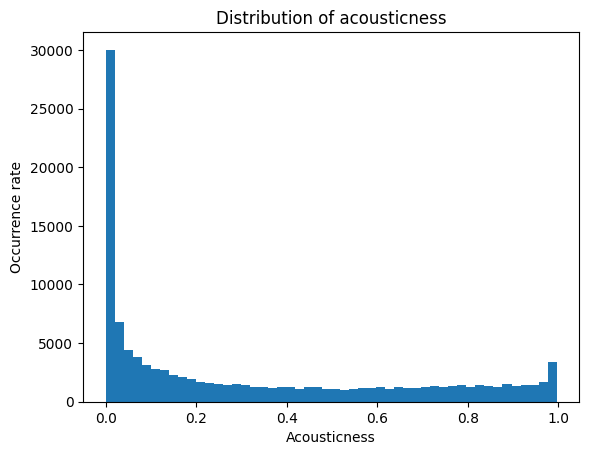

In [9]:
# get distribution of acousticness

plt.hist(tracks_df["acousticness"].values, bins = 50)
plt.xlabel("Acousticness")
plt.ylabel("Occurrence rate")
plt.title("Distribution of acousticness")
#plt.xlim(0, 100)
#plt.ylim(0, 4000)
plt.show()

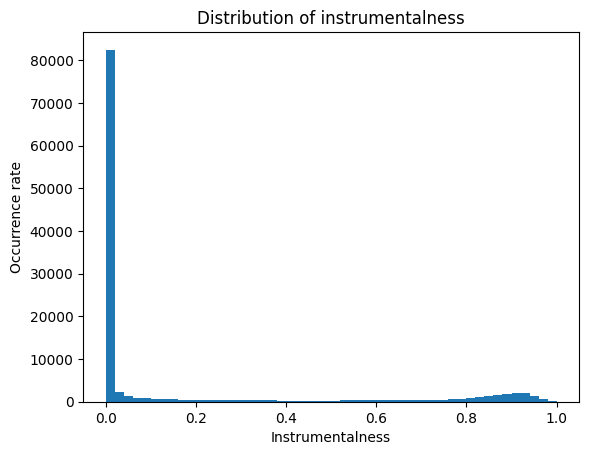

In [10]:
# get distribution of instrumentalness

plt.hist(tracks_df["instrumentalness"].values, bins = 50)
plt.xlabel("Instrumentalness")
plt.ylabel("Occurrence rate")
plt.title("Distribution of instrumentalness")
#plt.xlim(0, 100)
#plt.ylim(0, 4000)
plt.show()

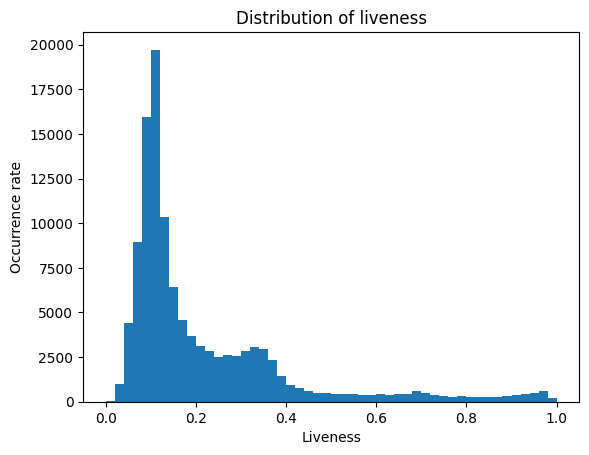

In [11]:
# get distribution of liveness

plt.hist(tracks_df["liveness"].values, bins = 50)
plt.xlabel("Liveness")
plt.ylabel("Occurrence rate")
plt.title("Distribution of liveness")
#plt.xlim(0, 100)
#plt.ylim(0, 4000)
plt.show()

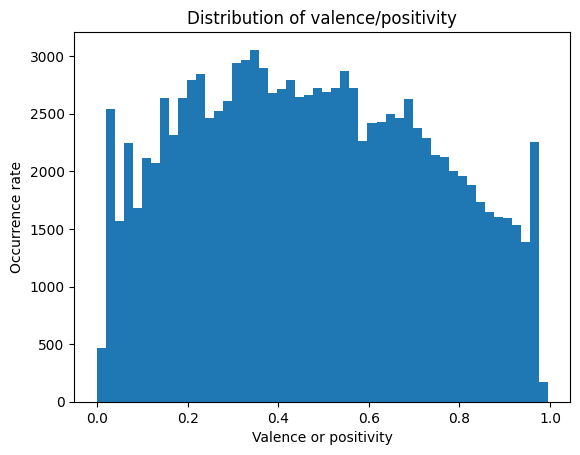

In [12]:
# get the distribution of valence (how are tracks distributed in terms of positivity)

plt.hist(tracks_df["valence"].values, bins = 50)
plt.xlabel("Valence or positivity")
plt.ylabel("Occurrence rate")
plt.title("Distribution of valence/positivity")
#plt.xlim(0, 100)
#plt.ylim(0, 4000)
plt.show()

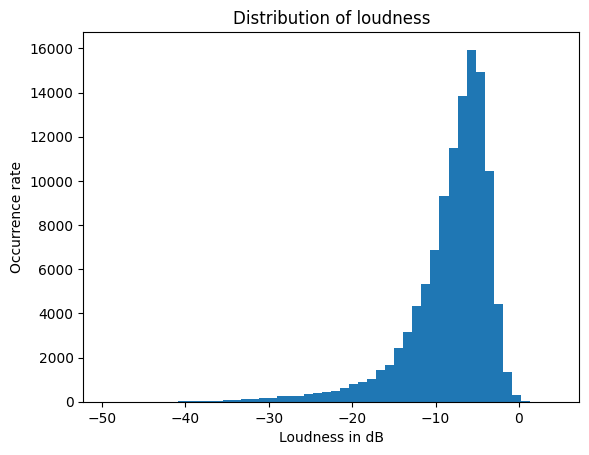

In [13]:
# get loudness distribution

plt.hist(tracks_df["loudness"].values, bins = 50)
plt.xlabel("Loudness in dB")
plt.ylabel("Occurrence rate")
plt.title("Distribution of loudness")
#plt.xlim(0, 100)
#plt.ylim(0, 4000)
plt.show()

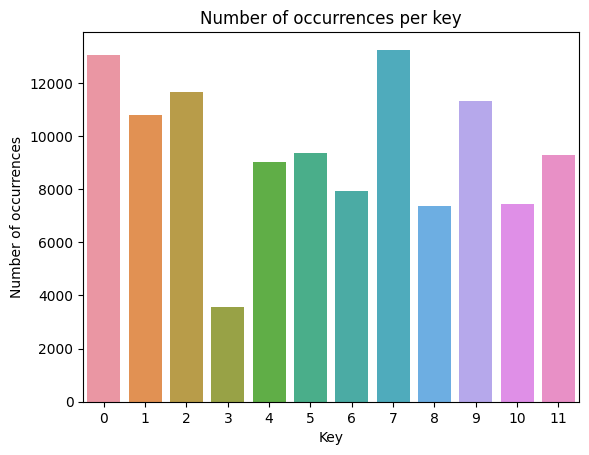

In [14]:
# get the number of items per each key in each track

balance = pd.DataFrame(tracks_df["key"].value_counts())
sns.barplot(balance, 
            x = balance.index, y = "count")
plt.xlabel("Key")
plt.ylabel("Number of occurrences")
plt.title("Number of occurrences per key")
plt.show()

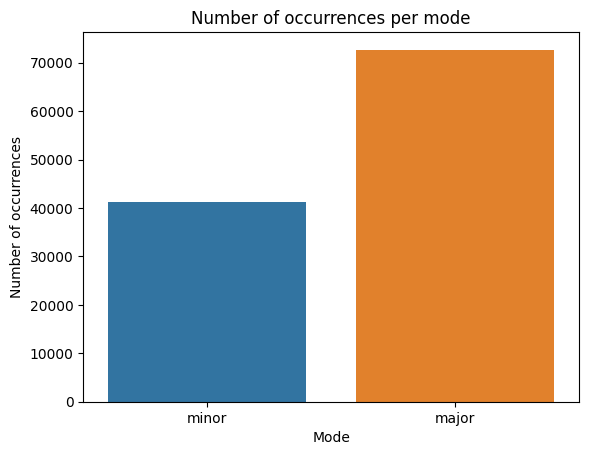

In [15]:
# get the number of tracks per mode (minor or major)

balance = pd.DataFrame(tracks_df["mode"].value_counts())
sns.barplot(balance, 
            x = balance.index, y = "count")
plt.xlabel("Mode")
plt.ylabel("Number of occurrences")
plt.title("Number of occurrences per mode")
plt.xticks([0, 1], ['minor', 'major']) 
plt.show()

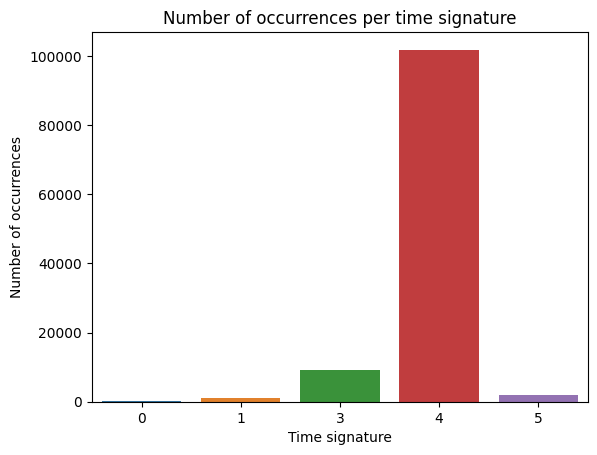

In [16]:
# get the number of tracks per each time signature

balance = pd.DataFrame(tracks_df["time_signature"].value_counts())
sns.barplot(balance, 
            x = balance.index, y = "count")
plt.xlabel("Time signature")
plt.ylabel("Number of occurrences")
plt.title("Number of occurrences per time signature")
#plt.xticks([0, 1], ['minor', 'major']) 
plt.show()

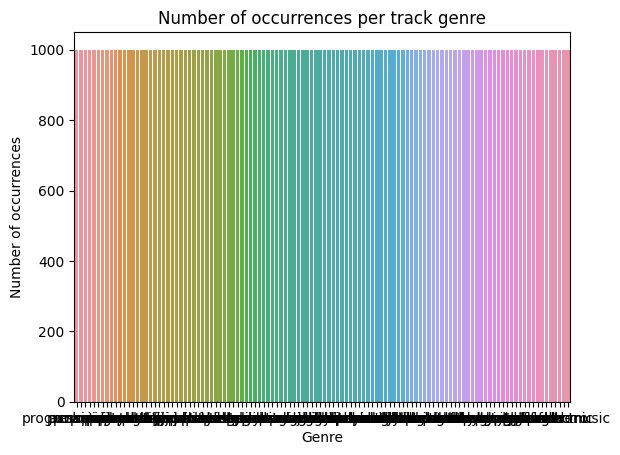

In [17]:
# get the number of tracks per genre

balance = pd.DataFrame(tracks_df["track_genre"].value_counts())
sns.barplot(balance, 
            x = balance.index, y = "count")
plt.xlabel("Genre")
plt.ylabel("Number of occurrences")
plt.title("Number of occurrences per track genre")
#plt.xticks([0, 1], ['minor', 'major']) 
plt.show()

When combining the observations from the graphs generated in data analysis step with the info provided by the dataset's home page in Kaggle, the following points were observed:

- Most items have low speechiness, and, therefore, are likely songs or non-speech tracks;
- Most items have low acusticness, with around 30k items being likely not acoustic at all;
- Most items are mostly vocal, with very few items being mostly instrumental;
- Most items are likely tracks not performed live;
- The number of tracks with valence below 0.5 (having more negative sound) is slightly higher than the number of tracks with valence above 0.5 (songs with more positive sound);
- Most items have low loudness;
- There are more tracks in major mode than minor mode;
- The track genre distribution is even.

After performing the analysis, it's time to continue with data processing.

# 3. Data Processing

First of all, I removed all data which I already saw to not having any notable contribution to the project's goals. This includes rows with null items and columns containing protected information of each item (like its name, its ID, the artist and the album it belongs to). As for the null values, I chose to remove them because there were so few that its absence wouldn't affect the amount of usable information in the dataset.

In [18]:
# Removing rows with null values
tracks_df = tracks_df.dropna()

for column in tracks_df.columns:
    print(f"Number of null items in column {column}: {tracks_df[column].isnull().sum()}")

Number of null items in column track_id: 0
Number of null items in column artists: 0
Number of null items in column album_name: 0
Number of null items in column track_name: 0
Number of null items in column popularity: 0
Number of null items in column duration_ms: 0
Number of null items in column explicit: 0
Number of null items in column danceability: 0
Number of null items in column energy: 0
Number of null items in column key: 0
Number of null items in column loudness: 0
Number of null items in column mode: 0
Number of null items in column speechiness: 0
Number of null items in column acousticness: 0
Number of null items in column instrumentalness: 0
Number of null items in column liveness: 0
Number of null items in column valence: 0
Number of null items in column tempo: 0
Number of null items in column time_signature: 0
Number of null items in column track_genre: 0


In [19]:
# Dropping unnamed column and other irrelevant columns
tracks_df = tracks_df.drop(["track_id", "artists", "album_name", "track_name"], axis = "columns")
tracks_df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


After removing non relevant info, I proceeded with finding and removing duplicate rows, so that it wouldn't affect model performance while also reducing the chances of it being biased. 

In [20]:
# Find duplicates
dupe_tracks = tracks_df[tracks_df.duplicated()]
print(f"Number of duplicated rows: {dupe_tracks.shape[0]}")

Number of duplicated rows: 7093


In [21]:
# Remove duplicates
tracks_df = tracks_df.drop_duplicates()
print(f"Dataset shape after removing duplicates: {tracks_df.shape}")

Dataset shape after removing duplicates: (106906, 16)


After removing duplicates, I moved on converting categorical columns to numerical ones. In other words, I converted, on each column, every value to a numerical equivalent. I did that so that the data could be in an appropriate format during training. \
As noticed during the EDA step, 6 columns had non-numeric values, of which only 2 were still present at this current step: explicit and track_genre. So I applied an encoder to each column so that they'd turn into numerical ones.

In [22]:
# Attributing numeric values to categorical columns

le = LabelEncoder()

tracks_df['explicit'] = le.fit_transform(tracks_df['explicit'])
tracks_df['track_genre'] = le.fit_transform(tracks_df['track_genre'])

tracks_df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0


Finally, I proceeded on checking the correlation between each column so that I could check which columns were similar to others. Columns with similar information to others are redundant, and thus need to be removed.

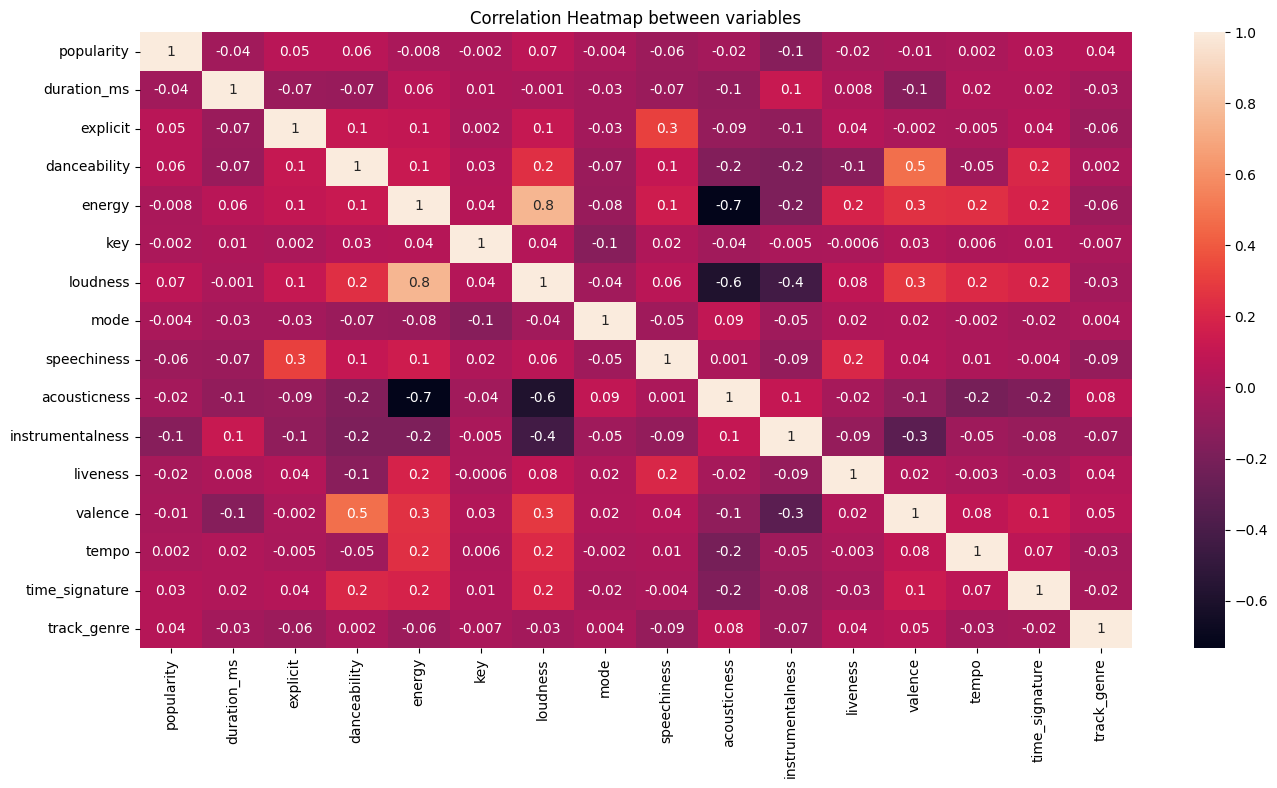

In [23]:
# Correlation between columns
corr_table = tracks_df.corr(method = "pearson")

plt.figure(figsize=(16,8))
sns.heatmap(corr_table, annot=True, fmt=".1g")
plt.title("Correlation Heatmap between variables")
plt.show() #display the plot

In [24]:
# Removing columns with high correlation

tracks_df = tracks_df.drop(["energy"], axis = "columns")

After doing this initial processing, I generated the target column using the popularity column. As the goal of this project is creating a model which can predict if a song is likely to be popular or not, I defined a threshold to create a binary column called is_popular, which is the target column.

In [25]:
# Defining target column(s)

conditionlist = [
    (tracks_df['popularity'] >= 80) ,
    (tracks_df['popularity'] <80)]

choicelist = [1,0]
tracks_df['is_popular'] = np.select(conditionlist, choicelist, default='Not Specified')
tracks_df['is_popular'] = tracks_df['is_popular'].astype(int)

# defining X and y

y = tracks_df['is_popular']
X = tracks_df.drop(["is_popular", "popularity"], axis = "columns")


Once set both X (features) and y (targets), I managed to scale the X dataset, given each column has different value ranges. This resulted in a scaled dataset with a more homogeneous value range on all columns.

In [26]:
# Scaling X columns

ss = StandardScaler()
X = ss.fit_transform(X)

pd.DataFrame(data=X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.006181,-0.304862,0.638577,-1.210305,0.307518,-1.316454,0.534473,-0.846126,-0.518405,0.738241,0.946857,-1.151628,0.219751,-1.710183
1,-0.740549,-0.304862,-0.835008,-1.210305,-1.765008,0.759617,-0.085264,1.833942,-0.518391,-0.593610,-0.780093,-1.500046,0.219751,-1.710183
2,-0.176595,-0.304862,-0.731396,-1.491541,-0.282882,0.759617,-0.276667,-0.311795,-0.518409,-0.510693,-1.346748,-1.538704,0.219751,-1.710183
3,-0.258522,-0.304862,-1.721461,-1.491541,-2.017924,0.759617,-0.456921,1.776843,-0.518184,-0.432958,-1.258088,1.983165,-2.081878,-1.710183
4,-0.286897,-0.304862,0.304718,-0.929070,-0.272410,0.759617,-0.305471,0.466561,-0.518409,-0.687409,-1.165572,-0.081382,0.219751,-1.710183


As noticed by the last line of the cell above, all columns lost their repective labels, and the fit_transform function changed the X dataset in a numpy matrix.

# 4. Data Split

Once defined the X and y columns, it's time to split them into training, validation, and test sets. Using the appropriate size of 20% for the test, I first split the data into training and test sets.

In [27]:
# Splitting train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED, shuffle = True)

In [28]:
print(X_train.shape)

(85524, 14)


Then, using a stratified cross validation technique, I split the X_train and y_train sets into training and validation sets. X_train_split and y_train_split are gonna be used to train the model, while X_val_split and y_val_split will be used to validate its performance.

In [29]:
# Dividing training set into training and validation splits

skf = StratifiedKFold(n_splits = 5, random_state = SEED, shuffle = True)

# looping for doing the split
for _, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    
    # X_train is a numpy array, y_train is a pandas Series

    X_train_split, X_val_split = X_train[train_index], X_train[val_index]
    y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[val_index]

In [30]:
print("\t\tX_train_split\tX_val_split\ty_train_split\ty_val_split")
print(f'Dimensions:\t{X_train_split.shape}\t{X_val_split.shape}\t{y_train_split.shape}\t{y_val_split.shape}\n')

		X_train_split	X_val_split	y_train_split	y_val_split
Dimensions:	(68420, 14)	(17104, 14)	(68420,)	(17104,)



# 5. Baseline Model

Once prepared the training and validation data, I trained an initial model.

In [31]:
lr = LogisticRegression()
lr.fit(X_train_split, y_train_split)

y_preds_base_train = lr.predict(X_train_split)
y_preds_base_val = lr.predict(X_val_split)

In [32]:
# checking the contribution coefficient of each feature
data = {
    "Features": tracks_df.drop(["is_popular", "popularity"], axis = "columns").columns,
    "Coef": lr.coef_.tolist()[0]
}

df = pd.DataFrame(data)
df


,Features,Coef
0,duration_ms,-0.142433
1,explicit,0.263533
2,danceability,0.477646
3,key,0.097274
4,loudness,0.444487
5,mode,-0.007626
6,speechiness,-0.362769
7,acousticness,-0.369634
8,instrumentalness,-0.886171
9,liveness,-0.297997


# 6. Baseline model evaluation

After training the model, I checked its performance using the validation set.

In [33]:
# getting training metrics

print(f"Training accuracy: {accuracy_score(y_train_split, y_preds_base_train)}")
print(classification_report(y_train_split, y_preds_base_train))

Training accuracy: 0.9890382928968138
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     67670
           1       0.00      0.00      0.00       750

    accuracy                           0.99     68420
   macro avg       0.49      0.50      0.50     68420
weighted avg       0.98      0.99      0.98     68420



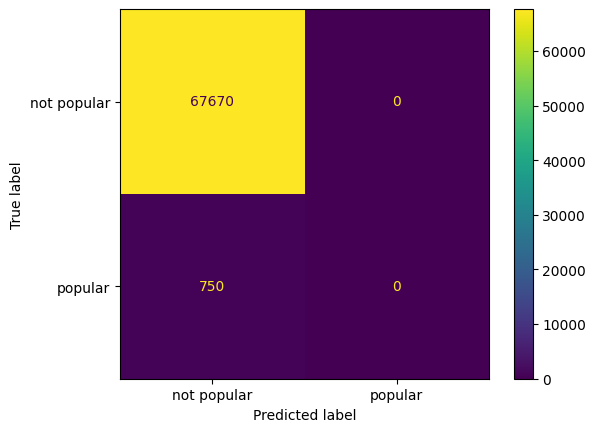

In [34]:
# confusion matrix

cm = confusion_matrix(y_train_split, y_preds_base_train, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr.classes_)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular']) 
plt.yticks([0, 1], ['not popular', 'popular']) 
plt.show()

In [36]:
# getting validation metrics

print(f"Validation accuracy: {accuracy_score(y_val_split, y_preds_base_val)}")
print(f"Validation classification report:\n{classification_report(y_val_split, y_preds_base_val)}")

Validation accuracy: 0.9890668849391955
Validation classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16917
           1       0.00      0.00      0.00       187

    accuracy                           0.99     17104
   macro avg       0.49      0.50      0.50     17104
weighted avg       0.98      0.99      0.98     17104



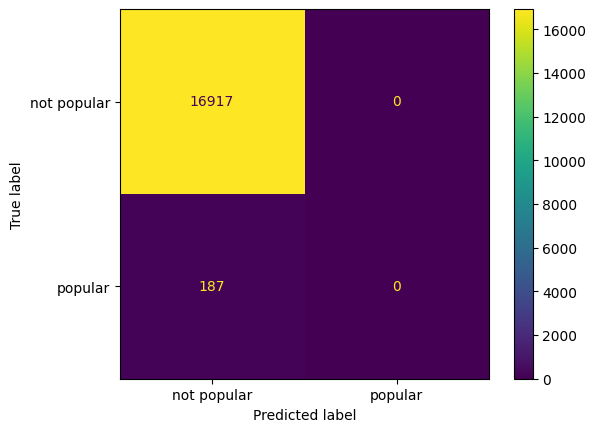

In [37]:
cm = confusion_matrix(y_val_split, y_preds_base_val, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr.classes_)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular']) 
plt.yticks([0, 1], ['not popular', 'popular']) 
plt.show()

# 7. Resampling and selecting best classifier

As noted in the training, the baseline model had an excellent accuracy but it poorly performed in other metrics, especially regarding the items which are labelled as popular (label '1' in is_popular column). This happens because there are many more items with label '0' (not popular) than label '1' (popular), as I used a high threshold when creating the target column. To solve that, I had to find a way to balance both classes so that each of them had the same amount of items. I used two resampling approaches (Random Oversampler and SMOTE) and tested the resampled data in 4 models, so that I could find the model and resample technique which perform the best.

In [38]:
# defining list of classifiers to be tested
classifier_list = {"LogisticRegression": LogisticRegression(),
                   "DecisionTree": DecisionTreeClassifier(),
                   "RandomForest": RandomForestClassifier(),
                   "GradientBoosting": GradientBoostingClassifier()
}

## 7.1. Random Oversampler

In this step, I tested the 4 models initialised before using the training set resampled using Random Oversampler technique.

In [39]:
# resample approach 1: Random Oversampling

sampler = RandomOverSampler(sampling_strategy="minority")

X_over, y_over = sampler.fit_resample(X_train_split, y_train_split)

counter = Counter(y_over)
print(counter)

Counter({0: 67670, 1: 67670})


In [40]:
for name, model in classifier_list.items():
    
    model.fit(X_over, y_over)
    y_pred = model.predict(X_val_split)
    
    print(f'Model:    {name}\n')
    print(f"Accuracy:  {accuracy_score(y_val_split, y_pred)}")
    print(f"Classification report:\n{classification_report(y_val_split, y_pred)}")
    print('---' * 20)

Model:    LogisticRegression

Accuracy:  0.6379794200187091
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78     16917
           1       0.02      0.79      0.05       187

    accuracy                           0.64     17104
   macro avg       0.51      0.71      0.41     17104
weighted avg       0.99      0.64      0.77     17104

------------------------------------------------------------
Model:    DecisionTree

Accuracy:  0.9825187090739008
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     16917
           1       0.28      0.37      0.32       187

    accuracy                           0.98     17104
   macro avg       0.63      0.68      0.65     17104
weighted avg       0.99      0.98      0.98     17104

------------------------------------------------------------
Model:    RandomForest

Accuracy:  0.9914055191768008
Classifica

## 7.2. SMOTE

In this step, I tested the 4 models initialised before using the training set resampled using SMOTE technique.

In [41]:
# resample approach 2: SMOTE

sampler = SMOTE(sampling_strategy="minority")

X_smote, y_smote = sampler.fit_resample(X_train_split, y_train_split)

counter = Counter(y_over)
print(counter)

Counter({0: 67670, 1: 67670})


In [42]:
for name, model in classifier_list.items():
    
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_val_split)
    
    print(f'Model:    {name}\n')
    print(f"Accuracy:  {accuracy_score(y_val_split, y_pred)}")
    print(f"Classification report:\n{classification_report(y_val_split, y_pred)}")
    print('---' * 20)

Model:    LogisticRegression

Accuracy:  0.6573900841908326
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.66      0.79     16917
           1       0.02      0.78      0.05       187

    accuracy                           0.66     17104
   macro avg       0.51      0.72      0.42     17104
weighted avg       0.99      0.66      0.78     17104

------------------------------------------------------------
Model:    DecisionTree

Accuracy:  0.9584307764265669
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     16917
           1       0.11      0.39      0.17       187

    accuracy                           0.96     17104
   macro avg       0.55      0.67      0.57     17104
weighted avg       0.98      0.96      0.97     17104

------------------------------------------------------------
Model:    RandomForest

Accuracy:  0.9890084190832554
Classifica

From the tests performed, the Random Forest model and the Random Oversampler resampling performed the best, as both combined showed the best performance regarding evaluated metrics. As a result, the selected model and resampling technique are the following: \
\
Selected model: Random Forest \
Selected resampling technique: Random Oversampler

## 7.3. Fine-tuning hyperparameters in selected model

After selecting the model, it was time to check which parameters allowed the model to perform the best with the resampled data. In order to do that, a hyperparameter grid was created, and, using this grid combined with cross-validation in a pipeline, the best model was found.

In [43]:
# fine-tuning selected model hyperparameters

n_estimators = [20, 50, 100, 200]
max_depth = [2, 3, 5, 6, None]
max_features = [3, 4, 5, 6, None]
class_weight = ["balanced", None]

param_grid = {"n_estimators": n_estimators,
              "max_features": max_features,
             "max_depth": max_depth,
             "class_weight": class_weight}

cv_grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, random_state = SEED)

for train, test in skf.split(X_train, y_train):
    
    pipeline_rf = make_pipeline(RandomOverSampler(sampling_strategy='minority'), cv_grid)
    
    model_rf = pipeline_rf.fit(X_train[train], y_train.iloc[train])
    
    best_estimator_rf = cv_grid.best_estimator_
    
    preds_rf = best_estimator_rf.predict(X_train[test])

print(f"Best parameters for Random Forest: {cv_grid.best_params_}")
print(f"Classification report:\n{classification_report(y_val_split, preds_rf)}")

Best parameters for Random Forest: {'n_estimators': 200, 'max_features': 6, 'max_depth': None, 'class_weight': 'balanced'}
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16917
           1       0.62      0.37      0.46       187

    accuracy                           0.99     17104
   macro avg       0.81      0.68      0.73     17104
weighted avg       0.99      0.99      0.99     17104



And a ROC-AUC graph was generated to graphically evaluate the final model's performance.

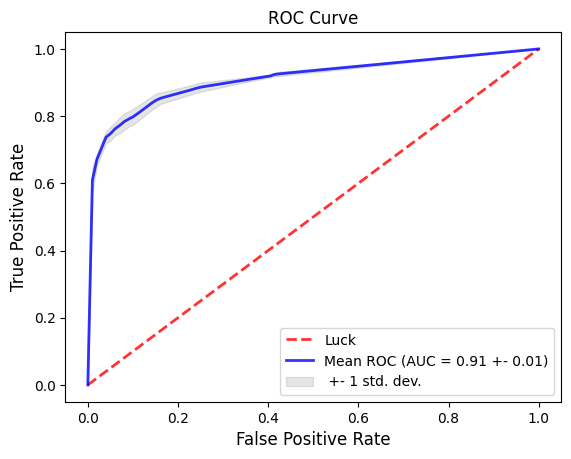

In [45]:
# initial lists

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train, test in skf.split(X_train, y_train):

    probs = best_estimator_rf.fit(X_train[train], y_train.iloc[train]).predict_proba(X_train[test])

    # computing ROC-AUC curve
    
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probs[:, 1])
    
    #print(probs)
    
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
# plotting reference line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

# getting means and std
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# plotting ROC-AUC curve
plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f +- %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r' +- 1 std. dev.')

# editing graph
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title("ROC Curve")
plt.legend(loc="lower right")
    
# showing graph
plt.show()

# 8. Applying model in test data and saving it

Once the final model was found, it was time to train it using the whole training set.

In [46]:
# getting final model

final_model = cv_grid.best_estimator_

pipeline = make_pipeline(RandomOverSampler(sampling_strategy='minority'), final_model)

model = pipeline.fit(X_train, y_train)

After training the model, I tested it and evaluated it using the test set:

In [47]:
# using test data to make predictions

y_pred_test = model.predict(X_test)

# metrics

print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"Classification report:\n{classification_report(y_test, y_pred_test)}")

Accuracy: 0.9894771302965111
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21121
           1       0.63      0.34      0.44       261

    accuracy                           0.99     21382
   macro avg       0.81      0.67      0.72     21382
weighted avg       0.99      0.99      0.99     21382



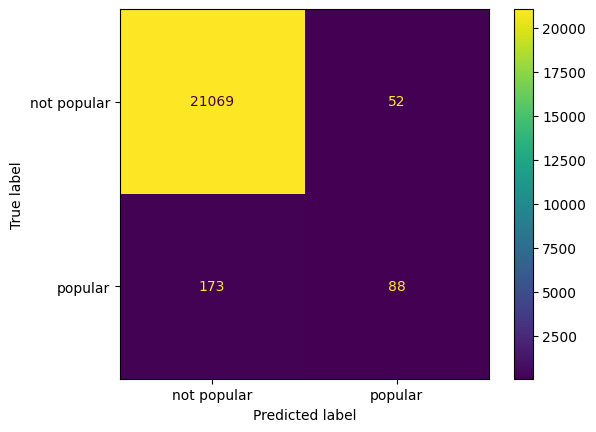

In [48]:
# confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr.classes_)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular']) 
plt.yticks([0, 1], ['not popular', 'popular']) 
plt.show()

Finally, after done testing and evaluation, I saved the model.

In [50]:
# saving results

pkl_filename_model = "/kaggle/working/RandomForestModel.pkl"
with open(pkl_filename_model, 'wb') as file:
    pkl.dump(model, file)